# TF2.0---文本卷积


In [3]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.0.0-alpha0


### [pad_sequences序列预处理](https://blog.csdn.net/yangfengling1023/article/details/81202767)

In [4]:
num_features =3000
sequence_length =300
embedding_dimension =100

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_features)
# num_words 只保留词频前3000的单词  https://blog.csdn.net/qq_23869697/article/details/86505343
print(x_train.shape,'\n',x_test.shape,'\n',y_train.shape,'\n',y_test.shape)

(25000,) 
 (25000,) 
 (25000,) 
 (25000,)


In [9]:
x_train = pad_sequences(x_train, maxlen=sequence_length)
x_test = pad_sequences(x_test, maxlen=sequence_length)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000, 300)
(25000, 300)
(25000,)
(25000,)


## 2. 构建基本句子分类器

In [14]:
def imdb_cnn():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension, input_length=sequence_length),
        layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid'),
        layers.MaxPool1D(2, padding='valid'),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy']
                 )
    return model

In [15]:
model = imdb_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 50)           25050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7400)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                74010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 399,071
Trainable params: 399,071
Non-trainable params: 0
__________________________________________________

In [17]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 19s 826us/sample - loss: 0.0043 - accuracy: 0.9997 - val_loss: 0.5707 - val_accuracy: 0.8724
Epoch 2/5
22500/22500 [==============================] - 19s 826us/sample - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.6184 - val_accuracy: 0.8716
Epoch 3/5
22500/22500 [==============================] - 19s 846us/sample - loss: 3.3721e-04 - accuracy: 1.0000 - val_loss: 0.6688 - val_accuracy: 0.8720
Epoch 4/5
22500/22500 [==============================] - 19s 850us/sample - loss: 1.8725e-04 - accuracy: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.8736
Epoch 5/5
22500/22500 [==============================] - 19s 844us/sample - loss: 1.2759e-04 - accuracy: 1.0000 - val_loss: 0.7268 - val_accuracy: 0.8748
CPU times: user 4min 15s, sys: 10.9 s, total: 4min 26s
Wall time: 1min 34s


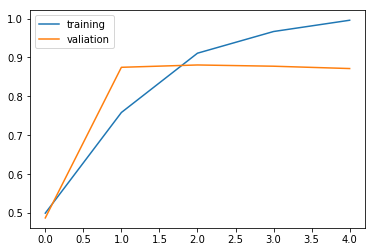

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

## 3. 多核卷积网络


In [19]:
filter_sizes=[3,4,5]
def convolution():
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(filters=64, kernel_size=(size, embedding_dimension),
                            strides=1, padding='valid', activation='relu')(inn)
        pool = layers.MaxPool2D(pool_size=(sequence_length-size+1, 1), padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)
    
    model = keras.Model(inputs=inn, outputs=outt)
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,
                        input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
        
    ])
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    return model

model = cnn_mulfilter()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape (Reshape)            (None, 300, 100, 1)       0         
_________________________________________________________________
model (Model)                (None, 1, 1, 192)         76992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1930      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 38s 2ms/sample - loss: 0.4570 - accuracy: 0.7742 - val_loss: 0.3109 - val_accuracy: 0.8692
Epoch 2/5
22500/22500 [==============================] - 36s 2ms/sample - loss: 0.2666 - accuracy: 0.8972 - val_loss: 0.2868 - val_accuracy: 0.8804
Epoch 3/5
22500/22500 [==============================] - 36s 2ms/sample - loss: 0.1870 - accuracy: 0.9347 - val_loss: 0.2910 - val_accuracy: 0.8872
Epoch 4/5
22500/22500 [==============================] - 36s 2ms/sample - loss: 0.1250 - accuracy: 0.9610 - val_loss: 0.3216 - val_accuracy: 0.8860
Epoch 5/5
22500/22500 [==============================] - 36s 2ms/sample - loss: 0.0783 - accuracy: 0.9780 - val_loss: 0.3523 - val_accuracy: 0.8852
CPU times: user 10min 2s, sys: 4.38 s, total: 10min 7s
Wall time: 3min 1s


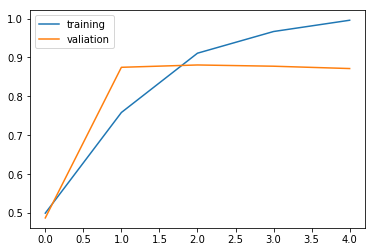

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()